Reporte por clase:

              precision    recall  f1-score   support

           A       0.57      0.73      0.64       145
           N       0.96      0.92      0.94       965

    accuracy                           0.89      1110
   macro avg       0.76      0.82      0.79      1110
weighted avg       0.91      0.89      0.90      1110

Métricas globales:
Accuracy : 0.8919
Precision: 0.9067
Recall   : 0.8919
F1-Score : 0.8975


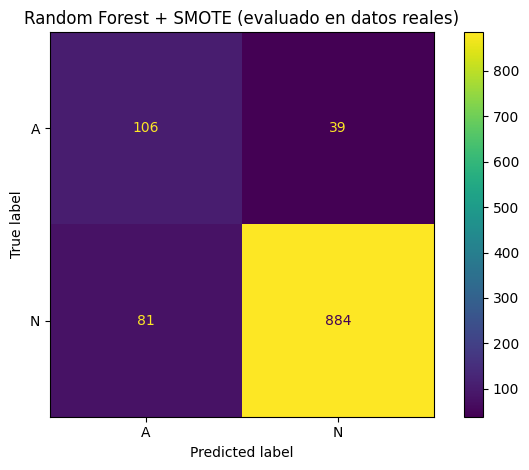

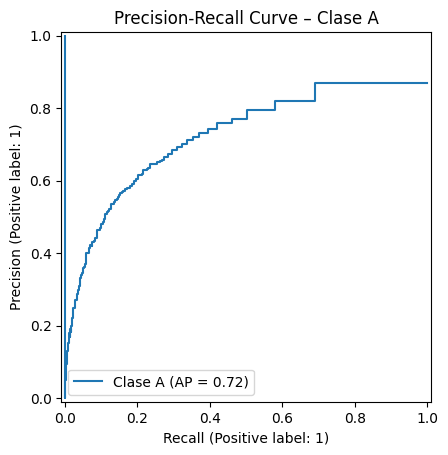

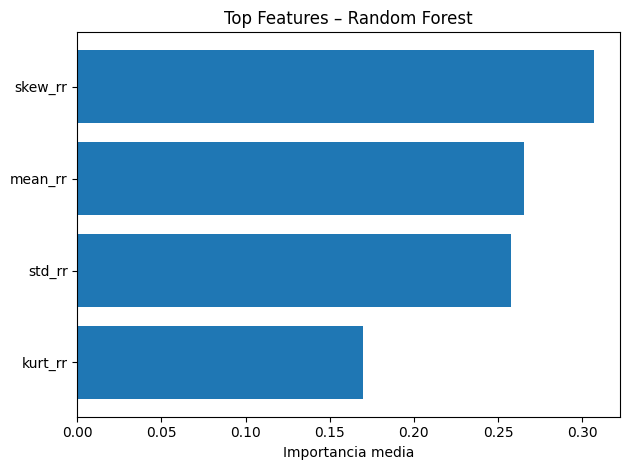

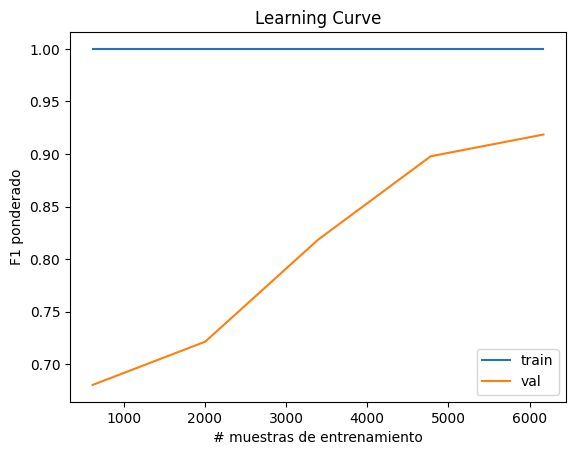

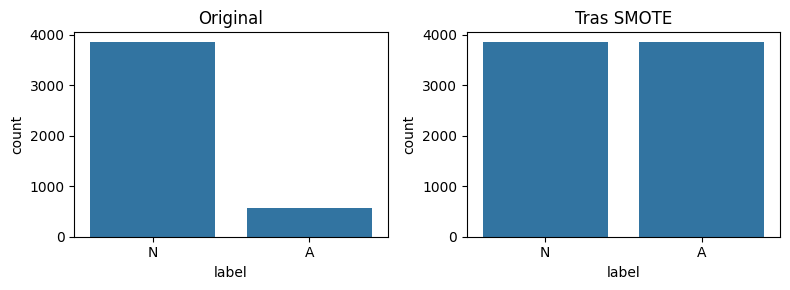

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, ConfusionMatrixDisplay,
    PrecisionRecallDisplay
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize

# Cargar el dataset
df = pd.read_csv("../data/ecg_rr_features_curado.csv")

# Separar características y etiquetas
X = df.drop(columns=["record", "label"])
y = df["label"]

# Imputar valores faltantes
X = SimpleImputer(strategy="mean").fit_transform(X)

# Dividir antes de aplicar SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Predicciones
y_pred = clf.predict(X_test)

# Reporte por clase
print("Reporte por clase:\n")
print(classification_report(y_test, y_pred))

# Métricas globales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Métricas globales:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest + SMOTE (evaluado en datos reales)")
plt.tight_layout()
plt.show()

# =============================
# GRÁFICOS ADICIONALES
# =============================

# 1. Precision-Recall Curve – Clase A
y_test_bin = label_binarize(y_test, classes=["A", "N"])
y_score = clf.predict_proba(X_test)
PrecisionRecallDisplay.from_predictions(y_test_bin[:, 0], y_score[:, 0], name="Clase A")
plt.title("Precision-Recall Curve – Clase A")
plt.show()

# 2. Importancia de variables
importances = clf.feature_importances_
feat_names = df.drop(columns=["record", "label"]).columns
idx = np.argsort(importances)[::-1][:15]
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), feat_names[idx][::-1])
plt.xlabel("Importancia media")
plt.title("Top Features – Random Forest")
plt.tight_layout()
plt.show()

# 3. Learning Curve
train_sizes, tr_scores, val_scores = learning_curve(
    clf, X_train_smote, y_train_smote, cv=5, scoring="f1_weighted", n_jobs=-1
)
plt.plot(train_sizes, tr_scores.mean(1), label="train")
plt.plot(train_sizes, val_scores.mean(1), label="val")
plt.xlabel("# muestras de entrenamiento")
plt.ylabel("F1 ponderado")
plt.title("Learning Curve")
plt.legend()
plt.show()

# 4. Distribución de clases (antes y después de SMOTE)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Original")
sns.countplot(x=y_train_smote, ax=ax[1])
ax[1].set_title("Tras SMOTE")
plt.tight_layout()
plt.show()


## 📊 Análisis de Resultados del Modelo

Modelo: **Random Forest + SMOTE**  
Evaluación: **Sobre conjunto de prueba real (sin datos sintéticos)**  
Total de muestras: **1110**

---

### 🔎 Desempeño por Clase

| Clase | Precisión | Recall | F1-Score | Soporte |
|-------|-----------|--------|----------|---------|
| **A** (fibrilación) | 0.57 | 0.73 | 0.64 | 145 |
| **N** (normal)      | 0.96 | 0.92 | 0.94 | 965 |

- La clase **A** muestra un **recall elevado (0.73)**, lo cual es positivo para detección clínica.
- La **precisión (0.57)** indica que aún hay falsos positivos, pero se compensa con un buen F1.
- El modelo se comporta **excelente para clase N**, como es esperado por su mayor representación.

---

### 📈 Métricas Globales

- **Accuracy:** `0.8919`
- **Precisión ponderada:** `0.9067`
- **Recall ponderado:** `0.8919`
- **F1-Score ponderado:** `0.8975`

Estas métricas reflejan un rendimiento general muy sólido, especialmente considerando el desbalance de clases inicial.

---

### ⚖️ Macro Promedio (igual peso entre clases)

- **F1 macro:** ~`0.79`

Esta métrica es más justa en contextos desbalanceados, y muestra que el modelo logra mantener un rendimiento equilibrado entre ambas clases.

---

### ✅ Conclusión

El modelo entrenado con **SMOTE** logra un **buen equilibrio entre sensibilidad y precisión**, especialmente en la clase minoritaria A. A pesar de una precisión moderada, su alto recall lo hace **apropiado para aplicaciones clínicas**, donde es preferible detectar más casos verdaderos incluso si se aceptan algunos falsos positivos.

